# Plotting OpenFE results against experiment using Cinnabar v0.3

This notebook shows how one would go about creating a cinnabar plot of OpenFE results against known experimental values.

In [1]:
# First we do a set of imports
import csv
from pprint import pprint
import cinnabar
from cinnabar import plotting as cinnabar_plotting
from cinnabar.wrangle import FEMap

## Loading experimental data

First we load our known experimental data from a tab separated values (TSV) file.

The format of the TSV file is as follows:

```
ligand  estimate (kcal/mol)     uncertainty (kcal/mol)
```

**Important note:**
Please note that for now you must have an experimental entry for every ligand involved in your free energy network.
In future versions of cinnabar this will no longer be needed.

In [2]:
# read in the experimental data

experimental_data = {}
experimental_filename = 'experimental.tsv'

with open(experimental_filename, 'r') as fd:
    rd = csv.reader(fd, delimiter="\t", quotechar='"')
    headers = next(rd)
    for row in rd:
        experimental_data[row[0]] = {}
        experimental_data[row[0]]['dG'] = float(row[1])
        experimental_data[row[0]]['ddG'] = float(row[2])

pprint(experimental_data)

{'lig_ejm_31': {'dG': -9.57, 'ddG': 0.18},
 'lig_ejm_42': {'dG': -9.81, 'ddG': 0.18},
 'lig_ejm_43': {'dG': -8.29, 'ddG': 0.18},
 'lig_ejm_45': {'dG': -9.59, 'ddG': 0.18},
 'lig_ejm_46': {'dG': -11.35, 'ddG': 0.17},
 'lig_ejm_47': {'dG': -9.73, 'ddG': 0.18},
 'lig_ejm_48': {'dG': -9.03, 'ddG': 0.18},
 'lig_ejm_50': {'dG': -9.01, 'ddG': 0.18},
 'lig_ejm_54': {'dG': -10.57, 'ddG': 0.18},
 'lig_ejm_55': {'dG': -9.24, 'ddG': 0.18},
 'lig_jmc_23': {'dG': -11.74, 'ddG': 0.18},
 'lig_jmc_27': {'dG': -11.31, 'ddG': 0.17},
 'lig_jmc_28': {'dG': -11.01, 'ddG': 0.18}}


## Loading free energy results

Next we load in results from the TSV file created by `openfe gather`.

Please see the following tutorial for more information on how to run the gather command: https://github.com/OpenFreeEnergy/ExampleNotebooks/blob/main/rbfe_tutorial/cli_tutorial.md

In [3]:
# Read in calculated results

calculated_data = {}
calculated_filename = 'final_results.tsv'

with open(calculated_filename, 'r') as fd:
    rd = csv.reader(fd, delimiter="\t", quotechar='"')
    headers = next(rd)
    for row in rd:
        if 'DDGbind' not in row[0]:
            continue
            
        calculated_data[row[0]] = {}
        calculated_data[row[0]]['ligand_i'] = row[2]
        calculated_data[row[0]]['ligand_j'] = row[3]
        calculated_data[row[0]]['dG'] = float(row[4])
        calculated_data[row[0]]['ddG'] = float(row[5])

pprint(calculated_data)

{'DDGbind(lig_ejm_42, lig_ejm_31)': {'dG': 0.49,
                                     'ddG': 0.09,
                                     'ligand_i': 'lig_ejm_31',
                                     'ligand_j': 'lig_ejm_42'},
 'DDGbind(lig_ejm_43, lig_ejm_42)': {'dG': 1.2,
                                     'ddG': 0.14,
                                     'ligand_i': 'lig_ejm_42',
                                     'ligand_j': 'lig_ejm_43'},
 'DDGbind(lig_ejm_46, lig_ejm_31)': {'dG': -0.73,
                                     'ddG': 0.097,
                                     'ligand_i': 'lig_ejm_31',
                                     'ligand_j': 'lig_ejm_46'},
 'DDGbind(lig_ejm_47, lig_ejm_31)': {'dG': 0.016,
                                     'ddG': 0.15,
                                     'ligand_i': 'lig_ejm_31',
                                     'ligand_j': 'lig_ejm_47'},
 'DDGbind(lig_ejm_48, lig_ejm_31)': {'dG': 0.45,
                                     'ddG': 0

## Creating a Cinnabar CSV file

Next we take the data we've gathered above and write it out as `cinnabar` "csv" file.

In [4]:
cinnabar_filename = 'cinnabar_input.csv'

with open(cinnabar_filename, 'w') as f:
    f.write("# Experimental block\n")
    f.write("# Ligand, expt_DDG, expt_dDDG\n")
    for entry in experimental_data:
        dG = experimental_data[entry]['dG']
        ddG = experimental_data[entry]['ddG']
        f.write(f"{entry},{dG:.2f},{ddG:.2f}\n")
    f.write('\n')
    f.write('# Calculated block\n')
    f.write('# Ligand1,Ligand2,calc_DDG,calc_dDDG(MBAR),calc_dDDG(additional)\n')
    for entry in calculated_data:
        dG = calculated_data[entry]['dG']
        ddG = calculated_data[entry]['ddG']
        molA = calculated_data[entry]['ligand_i']
        molB = calculated_data[entry]['ligand_j']
        f.write(f"{molA},{molB},{dG:.2f},0,{ddG:.2f}\n")

## Plotting the results using Cinnabar

Once we've created the appropriate Cinnabar input file we can go ahead and plot out our results.

### Generating a Cinnabar FEMap and plotting out the network

First let's load the data into cinnabar and draw out the network of free energy results.

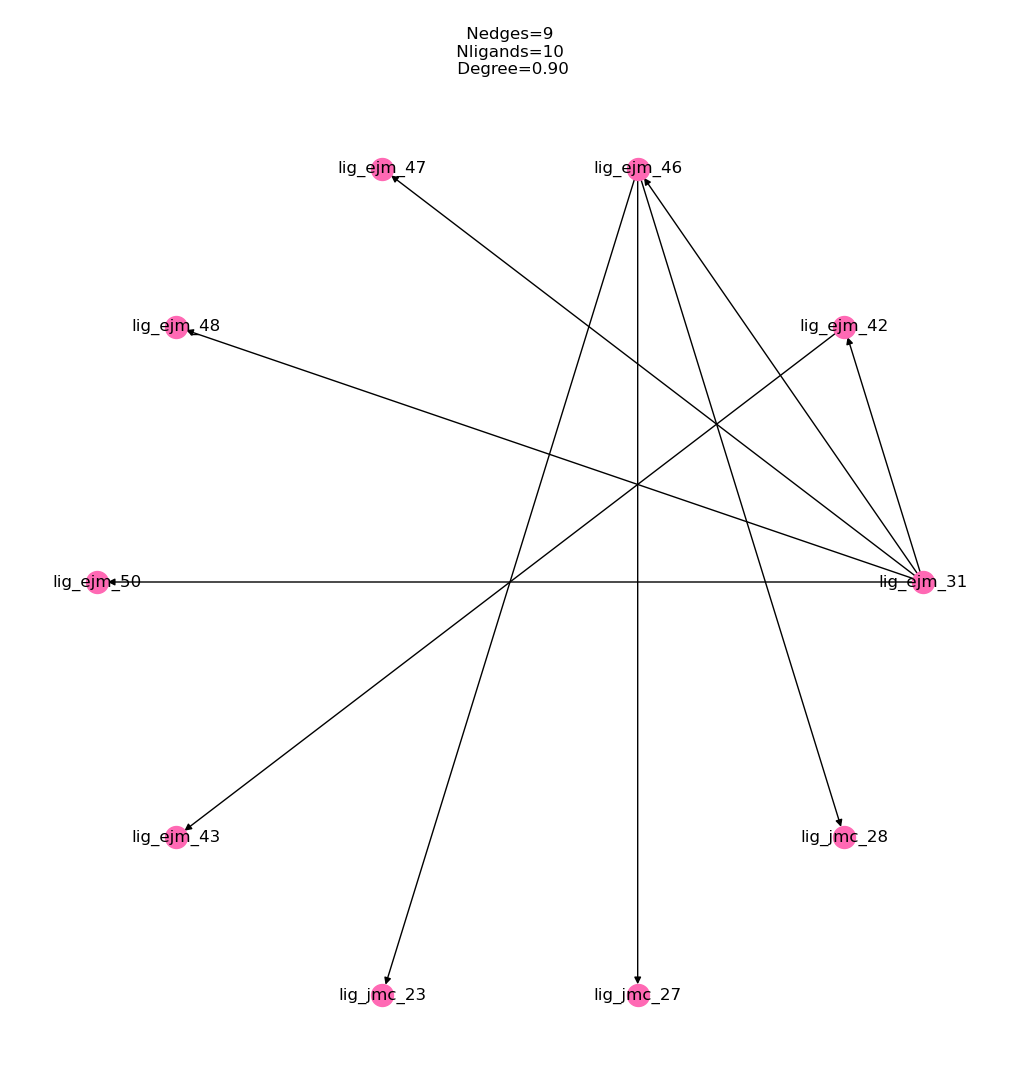

In [5]:
fe = cinnabar.wrangle.FEMap('cinnabar_input.csv')
fe.generate_absolute_values()  # Get MLE generated estimates of the absolute values
fe.draw_graph()

### Plotting out the relative free energy results

Next we can go ahead and plot out the relative free energy results.

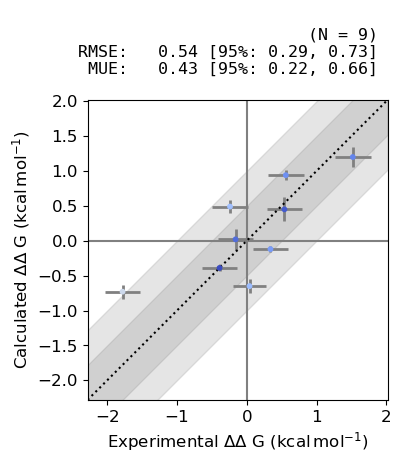

In [26]:
# note you can pass the filename argument to write things out to file
cinnabar_plotting.plot_DDGs(fe.graph, figsize=5)

### Plotting out the absolute free energy results

Finally let's go ahead and plot out the MLE derived absolute free energies

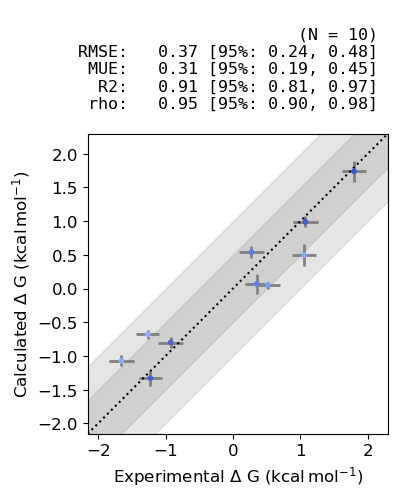

In [27]:
# note you can pass the filename argument to write to file
cinnabar_plotting.plot_DGs(fe.graph, figsize=5)

We can also shift our free energies by the average experimental value to have DGs on the same scale as experiment.

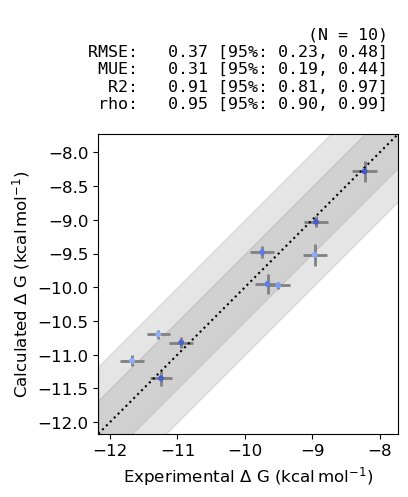

In [28]:
exp_DG_sum = sum([fe.results['Experimental'][i].DG for i in fe.results['Experimental'].keys()])
shift = exp_DG_sum / len(fe.results['Experimental'].keys())

cinnabar_plotting.plot_DGs(fe.graph, figsize=5,  shift=shift)

## Writing out the MLE derived absolute free energies

Finally, we can also write out the MLE derived absolute free energies through:

In [29]:
dG_results = {}
nodes = fe.graph.nodes(data=True)

for key in range(len(nodes)):
    dG_results[nodes[key]['name']] = {
        'experimental_estimate': nodes[key]['exp_DG'],
        'experimental_error': nodes[key]['exp_dDG'],
        'calculated_estimate': nodes[key]['exp_DG'],
        'calculated_error': nodes[key]['exp_dDG'],        
    }

# We can now print out the results
pprint(dG_results)

with open('dG_results.dat', 'w') as f:
    writer = csv.writer(f, delimiter="\t", lineterminator="\n")
    writer.writerow(["ligand", "calculated_estimate", "calculated_error",
                     "experimental_estimate", "estimated_error"])
    for ligand in dG_results:
        writer.writerow([
            ligand,
            dG_results[ligand]['calculated_estimate'],
            dG_results[ligand]['calculated_error'],
            dG_results[ligand]['experimental_estimate'],
            dG_results[ligand]['experimental_error'],
        ])

{'lig_ejm_31': {'calculated_error': 0.18,
                'calculated_estimate': -9.57,
                'experimental_error': 0.18,
                'experimental_estimate': -9.57},
 'lig_ejm_42': {'calculated_error': 0.18,
                'calculated_estimate': -9.81,
                'experimental_error': 0.18,
                'experimental_estimate': -9.81},
 'lig_ejm_43': {'calculated_error': 0.18,
                'calculated_estimate': -8.29,
                'experimental_error': 0.18,
                'experimental_estimate': -8.29},
 'lig_ejm_46': {'calculated_error': 0.17,
                'calculated_estimate': -11.35,
                'experimental_error': 0.17,
                'experimental_estimate': -11.35},
 'lig_ejm_47': {'calculated_error': 0.18,
                'calculated_estimate': -9.73,
                'experimental_error': 0.18,
                'experimental_estimate': -9.73},
 'lig_ejm_48': {'calculated_error': 0.18,
                'calculated_estimate': -9.03,
     